In [2]:
%load_ext autoreload
%autoreload 2

# PriorCVAE, for NeurIPS


In [5]:
import jax.numpy as jnp
# Numpyro

from jax import random
from numpyro.infer import Predictive

from reusable.gp import OneDGP_UnifLS
from reusable.kernels import esq_kernel

from reusable.util import (load_args, load_samples, load_training_history, load_training_state, get_decoder_params, gen_file_name)



In [7]:
args = load_args("14", "args")



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Examples of priors to encode

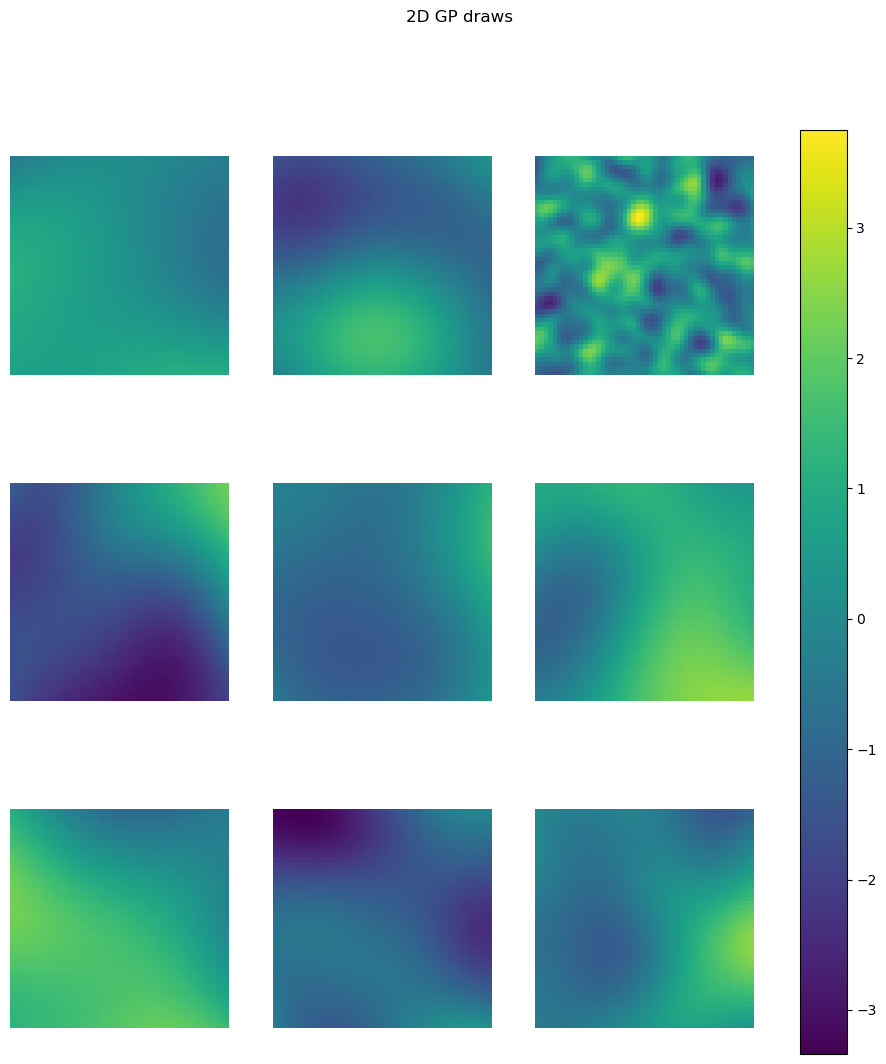

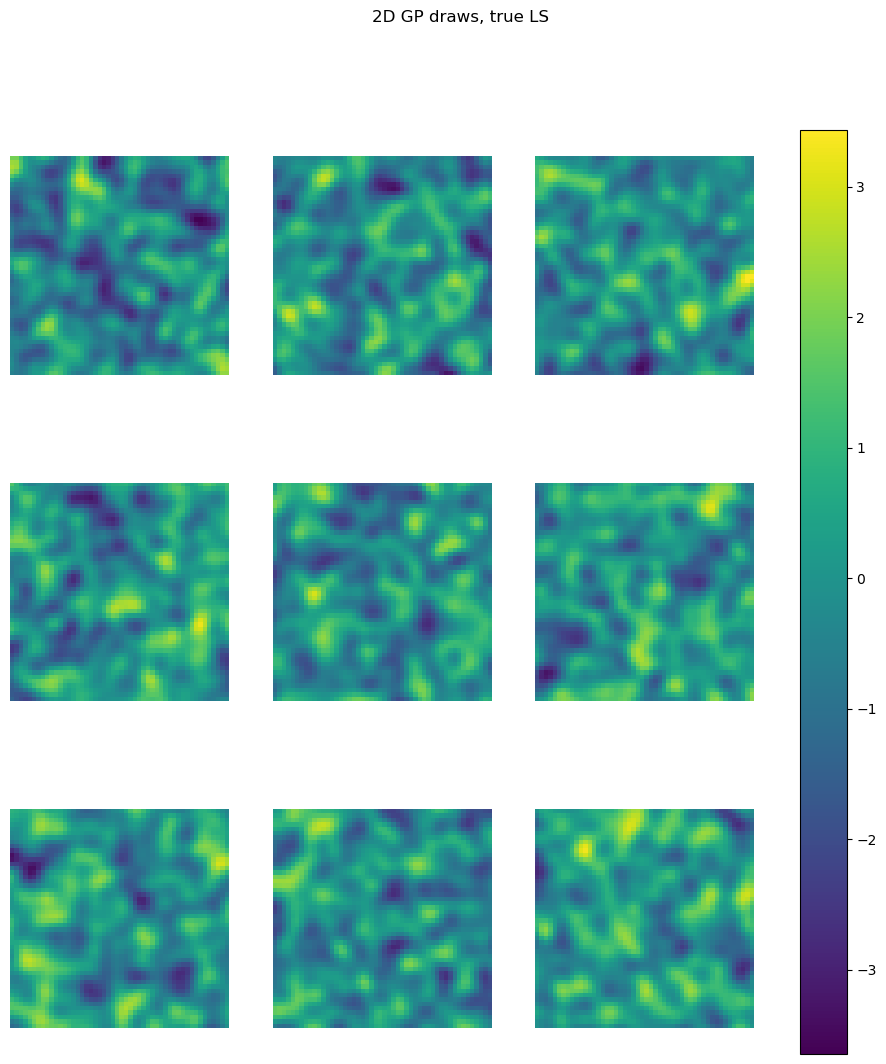

In [8]:
from plotting.plots import plot_2d_draws

rng_key_plots =  random.PRNGKey(5)

to_plot = 9

plot_pred = Predictive(OneDGP_UnifLS, num_samples=to_plot)
plot_samples = plot_pred(rng_key_plots, x=args["x"], gp_kernel=args["gp_kernel"], jitter=5e-5)

plot_2d_draws(plot_samples["y"].reshape(-1, *([args["n"]] * args["dim"])), to_plot, 3, "2D GP draws")

plot_samples = plot_pred(rng_key_plots, x=args["x"], gp_kernel=args["gp_kernel"], jitter=5e-5, length=0.05)

plot_2d_draws(plot_samples["y"].reshape(-1, *([args["n"]] * args["dim"])), to_plot, 3, "2D GP draws, true LS")


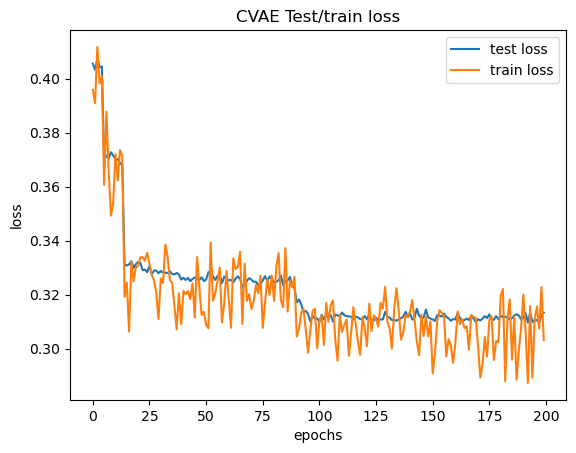

In [9]:
from plotting.plots import plot_training
from reusable.util import load_training_history, gen_file_name

metrics_history = load_training_history("14", gen_file_name("14", args))

plot_training(metrics_history["test_loss"], metrics_history["train_loss"], "CVAE Test/train loss", note="loss")


### Training progress

In [10]:
from flax.core.frozen_dict import freeze
from flax import serialization
from reusable.util import decoder_filename, get_savepath


file_path = f'{get_savepath()}/{decoder_filename("14/14", args)}'

dummy = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=True,
)
dummy_params = dummy.init(random.PRNGKey(0), jnp.ones((1, args["n"]** args["dim"]+1,)))

with open(file_path, "rb") as file:
    bytes = file.read()
    # serialization.to_bytes(freeze({"params": final_state.params["VAE_Decoder_0"]})))
    # new_dummy  =  freeze({"params" : dummy_params})
    new_state = serialization.from_bytes(dummy_params, bytes)
    args["decoder_params"] = freeze({"params": new_state["params"]["VAE_Decoder_0"]})


# if not args["pretrained_vae"]:
#     decoder_params = freeze({"params": state.params["VAE_Decoder_0"]})
#     args["decoder_params"] = decoder_params
#     with open(file_path, 'wb') as file:
#        file.write(serialization.to_bytes(decoder_params))

# if args["pretrained_vae"]:
#     from reusable.vae import VAE_Decoder
#     dummy_decoder = VAE_Decoder(hidden_dim1=args["hidden_dim1"],   hidden_dim2=args["hidden_dim2"], out_dim=args["n"])
#     dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))
#     with open(file_path, 'rb') as file:
#         bytes = file.read()
        
#         args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

## Demonstrations

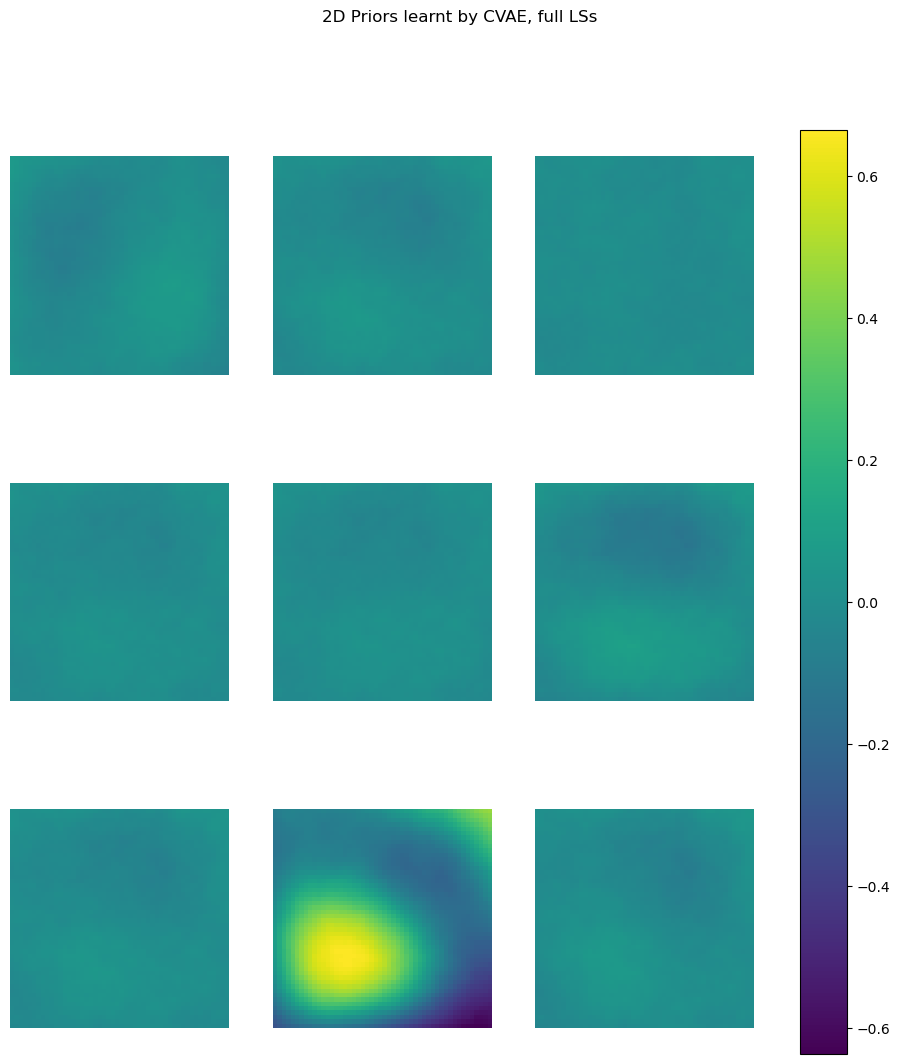

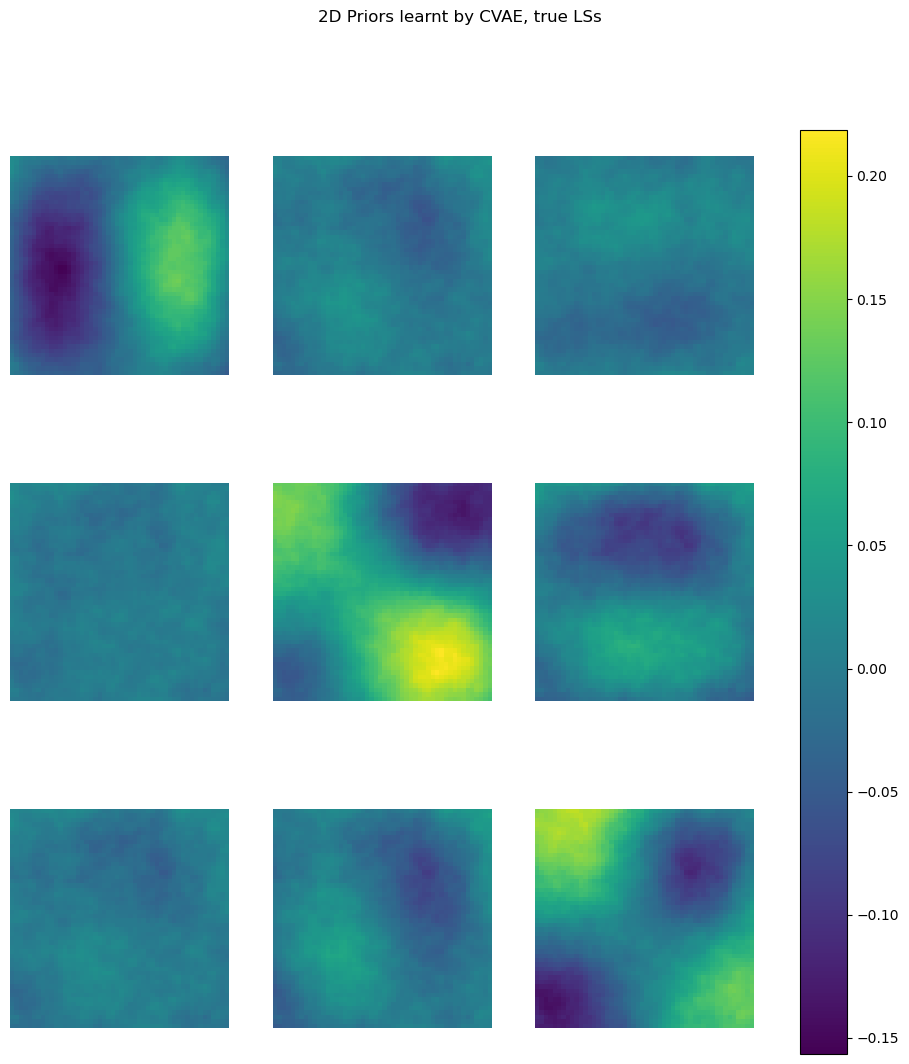

In [15]:
from reusable.vae import cvae_sample
from plotting.plots import compare_draws
rng_key, rng_key_predict = random.split(random.PRNGKey(2))

conditions = [(None, "full"), (0.05, "true"),]
for cond, label in conditions:

   
    plot_vae_predictive = Predictive(cvae_sample, num_samples=40)
    vae_draws = plot_vae_predictive(
        rng_key_predict,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"] ** args["dim"],
        decoder_params=args["decoder_params"],
        condition=cond
    )["f"]
    plot_2d_draws(jnp.reshape(vae_draws, (-1, *([args["n"]] * args["dim"]))), 9, 3, f"2D Priors learnt by CVAE, {label} LSs")


# Inference

Ground truth - true ls = 0.05

300


(-3.0683934688568115, 2.852506160736084)

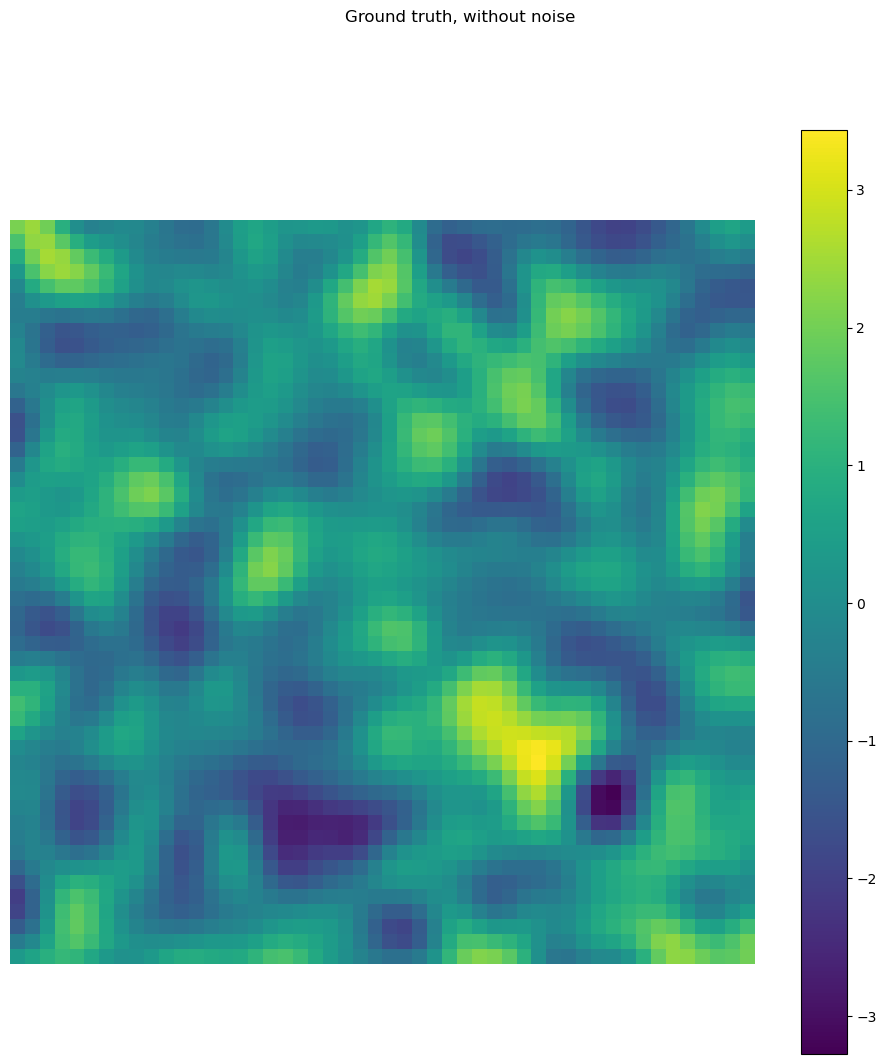

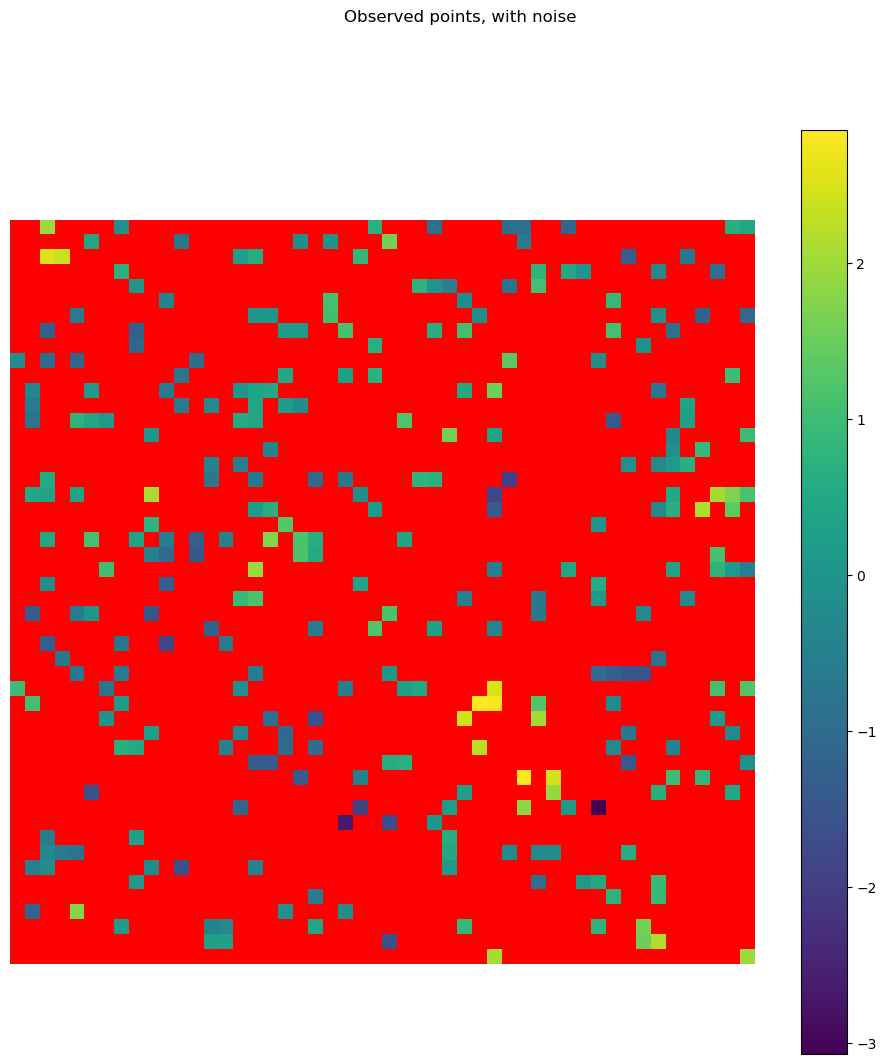

In [16]:
from reusable.gp import OneDGP_UnifLS
from plotting.plots import plot_2d_one_draw
rng_key_ground_truth = random.PRNGKey(
    4
)  # fixed to generate a "ground truth" GP we will try and infer

ground_truth_predictive = Predictive(OneDGP_UnifLS, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5, noise=True, length=0.05
)
ground_truth = gt_draws["f"][0]
ground_truth_y_draw = gt_draws["y"][0]

obs_idx = jnp.array([2,7,24,28,33,34,37,48,49,55,61,69,71,75,84,102,103,115,116,123,141,145,157,185,187,188,193,197,208,227,228,229,233,235,260,271,280,290,304,316,317,321,331,343,346,349,352,358,368,369,372,378,380,390,394,408,424,442,450,452,454,462,483,489,511,518,522,524,548,551,555,560,565,566,567,580,582,593,601,611,613,616,618,619,645,651,654,655,656,665,666,676,690,695,709,729,732,744,749,767,794,796,813,815,841,843,844,845,852,863,866,870,872,877,878,883,901,902,904,909,923,932,944,947,948,949,966,967,974,982,993,994,996,998,1009,1018,1039,1052,1055,1058,1060,1062,1064,1067,1069,1070,1076,1109,1110,1112,1119,1120,1147,1156,1166,1182,1187,1194,1197,1198,1199,1202,1210,1223,1239,1265,1266,1280,1285,1289,1295,1301,1304,1305,1309,1325,1335,1342,1363,1370,1374,1378,1382,1402,1407,1410,1414,1453,1493,1504,1507,1516,1525,1539,1540,1541,1542,1550,1556,1565,1572,1576,1577,1582,1597,1599,1601,1607,1631,1632,1635,1640,1656,1667,1670,1680,1685,1697,1709,1715,1718,1741,1748,1757,1758,1764,1768,1770,1781,1790,1794,1816,1817,1825,1826,1841,1849,1869,1873,1884,1886,1894,1896,1905,1930,1936,1943,1948,1965,1973,1979,1984,1987,1989,2022,2025,2028,2052,2058,2079,2102,2103,2104,2129,2133,2135,2136,2141,2151,2152,2159,2161,2166,2179,2208,2235,2238,2239,2243,2270,2290,2293,2301,2304,2318,2322,2357,2363,2364,2370,2380,2389,2392,2413,2414,2425,2442,2443,2482,2499]) # indexing into flattened array
obs_mask = jnp.isin(jnp.arange(0, args["n"] **args["dim"]), obs_idx, assume_unique=True)
print(obs_mask.sum())

ground_truth_y_obs = ground_truth_y_draw[obs_idx]
x_obs = jnp.arange(0, args["n"] **args["dim"])[obs_idx]


vmin, vmax = plot_2d_one_draw(ground_truth.reshape(([args["n"]] * args["dim"])), "Ground truth, without noise")
plot_2d_one_draw(ground_truth.reshape(([args["n"]] * args["dim"])), "Observed points, with noise", vmin=vmin, vmax=vmax, mask=~obs_mask )


## Inference: assume correct LS

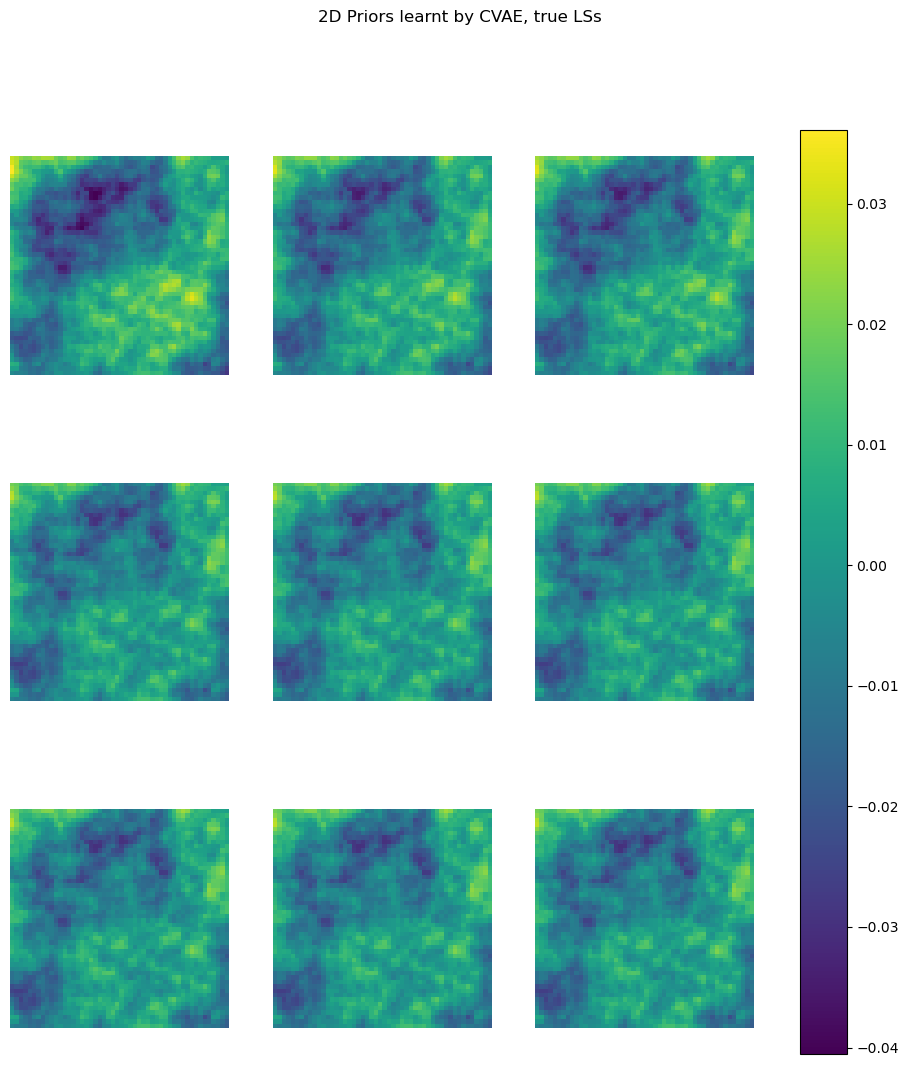

In [19]:
from reusable.vae import cvae_length_mcmc

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

with open(f'{get_savepath()}/{decoder_filename("14/14", args, suffix=f"inference_true_ls_mcmc_samples")}', "rb") as file:
    mcmc_samples = dill.load(file)

predictive = Predictive(cvae_length_mcmc, mcmc_samples)

predictions = predictive(rng_key_pred, hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"] ** args["dim"],
        decoder_params=args["decoder_params"], length=0.01)["f"]


plot_2d_draws(jnp.reshape(predictions, (-1, *([args["n"]] * args["dim"]))), 9, 3, f"2D Priors learnt by CVAE, {label} LSs")

## Inference: assume no LS

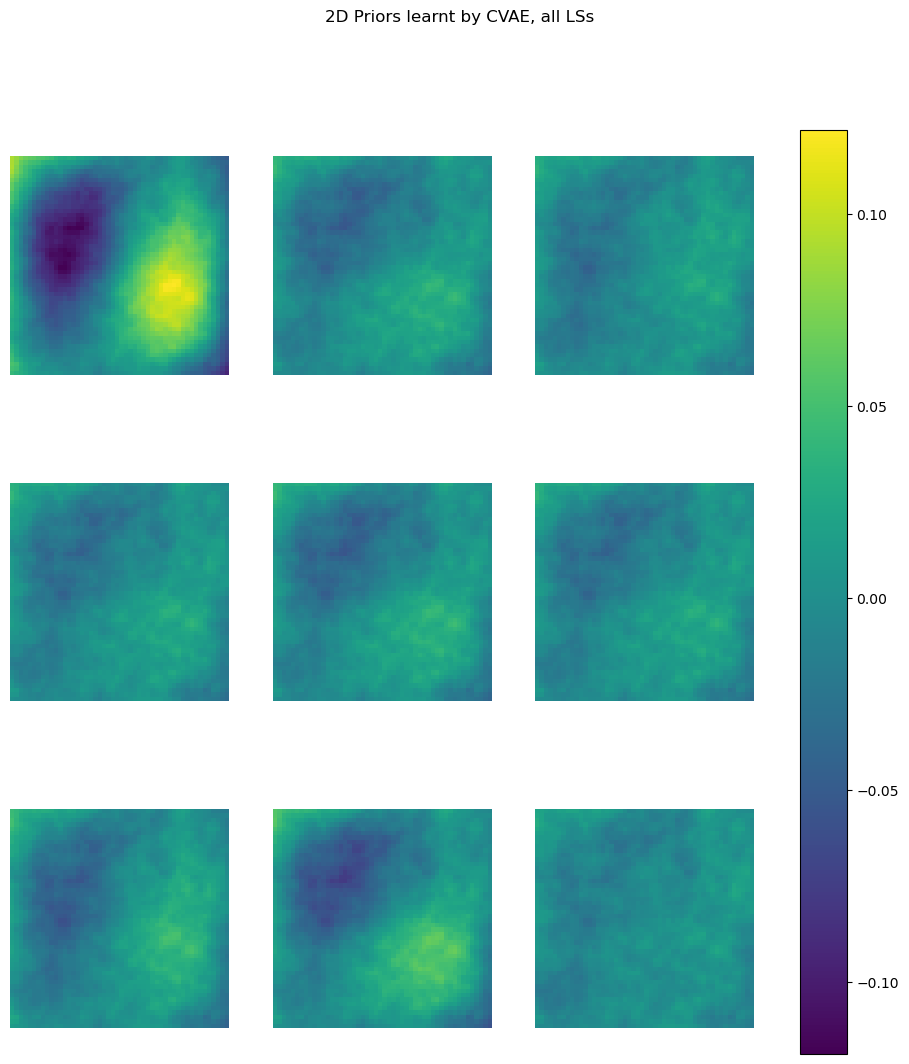

In [21]:
from reusable.vae import cvae_length_mcmc

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

with open(f'{get_savepath()}/{decoder_filename("14/14", args, suffix=f"inference_all_ls_mcmc_samples")}', "rb") as file:
    mcmc_samples = dill.load(file)


predictive = Predictive(cvae_length_mcmc, mcmc_samples)

predictions = predictive(rng_key_pred, hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"] ** args["dim"],
        decoder_params=args["decoder_params"], length=0.01)["f"]


plot_2d_draws(jnp.reshape(predictions, (-1, *([args["n"]] * args["dim"]))), 9, 3, f"2D inference predictions, all LSs")



# Posterior of lengthscale condition

Text(0.5, 1.0, 'c - posterior samples')

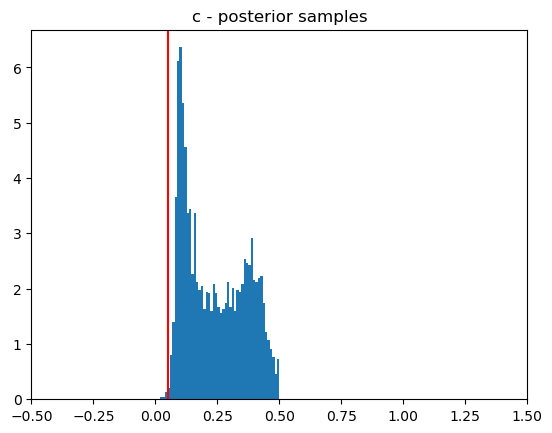

In [25]:
import matplotlib.pyplot as plt
c_samps = mcmc_samples['c']
plt.hist(c_samps, density=True, bins=50) 
plt.xlim(-0.5,1.5)
plt.axvline(x=0.05, color="red")
plt.title('c - posterior samples')